# Commparativa entre Random Forest y SVM

En este estudio se pretende evaluar la creación de modelos basados en máquinas de vector de soporte (SVM) y Random Forest. Con el objetivo de comprender con un problema determinado, como es la clasificación del tipo de cobertura forestal, las diferencias que existen a la hora de entrenar los diferentes modelos.

El conjunto de datos con el que vamos a trabajar se encuentra en el siguiente enlace: https://archive.ics.uci.edu/dataset/31/covertype

Este dataset ha sido generado para predecir el tipo de cubierta forestal únicamente a partir de variables cartográficas (sin datos de sensores remotos). El tipo de cubierta forestal real para una observación determinada (celda de 30 x 30 metros) se determinó a partir de los datos del Sistema de información de recursos (RIS) de la Región 2 del Servicio Forestal de EE. UU. (USFS). Las variables independientes se derivaron de datos obtenidos originalmente del Servicio Geológico de EE. UU. (USGS) y de datos del USFS. Los datos están en forma original (no escalados) y contienen columnas binarias (0 o 1) de datos para variables cualitativas independientes (áreas silvestres y tipos de suelo).

## Importación de datos y de librerias

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Análisis Descriptivo de los Datos

In [9]:
X.shape[0]

581012

- El dataset tiene **581,012** instancias.

#### Variables continuas y categóricas

In [11]:
# Tipo de dato de las variables
print('Tipo de datos de variables predictoras:\n')
print(X.dtypes.value_counts())
print('\nTipo de dato de la variable objetivo:\n')
print(y.dtypes)

Tipo de datos de variables predictoras:

int64    54
Name: count, dtype: int64

Tipo de dato de la variable objetivo:

Cover_Type    int64
dtype: object


- Como todas las variables son de tipo **int64**, vamos a ver cuantos valores únicos hay en cada variable, para determinar cuales de las variables son categóricas

In [13]:
unique_counts = X.nunique()
unique_obj = y.nunique()

# Clasificación entre continua o categórica (Poniendo umbral en 10 valores únicos)
cat_vars = unique_counts[unique_counts < 10].index
con_vars = unique_counts[unique_counts >= 10].index

print(f" Hay {len(cat_vars)} variables categóricas en el conjunto de características")
print(f" Hay {len(con_vars)} variables continuas en el conjunto de características")
print(unique_obj)

 Hay 44 variables categóricas en el conjunto de características
 Hay 10 variables continuas en el conjunto de características
Cover_Type    7
dtype: int64


- Hay 10 variables continuas y 45 categóricas, teniendo en cuenta la variable objetivo `Cover Type`.

In [15]:
# Distribución de la variable objetivo 
distribucion_clase = y.value_counts()
porcentaje = y.value_counts(normalize=True) * 100

print('Distribución de clases (nº de observaciones):\n')
print(distribucion_clase)

print('\nDistribución de clases (porcentajes):\n')
print(porcentaje)

Distribución de clases (nº de observaciones):

Cover_Type
2             283301
1             211840
3              35754
7              20510
6              17367
5               9493
4               2747
Name: count, dtype: int64

Distribución de clases (porcentajes):

Cover_Type
2             48.759922
1             36.460521
3              6.153746
7              3.530048
6              2.989095
5              1.633873
4              0.472796
Name: proportion, dtype: float64


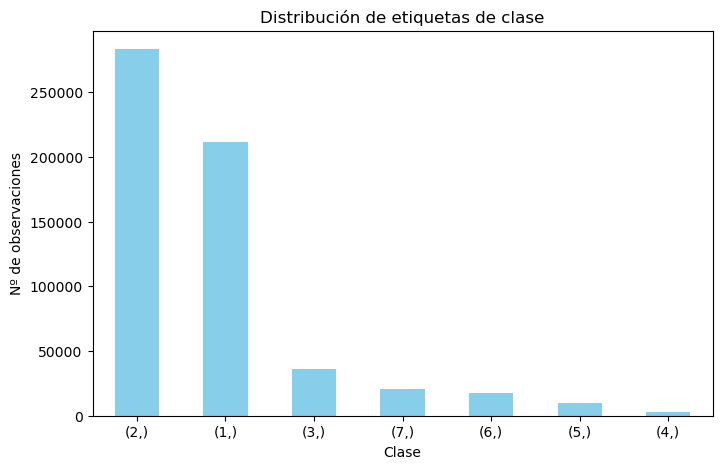

In [17]:
# Podemos verlo mejor con una representación gráfica:
distribucion_clase.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title('Distribución de etiquetas de clase')
plt.xlabel('Clase')
plt.ylabel('Nº de observaciones')
plt.xticks(rotation=0)
plt.show()

- El dataset esta desbalanceado, ya que las clases de tipo de cobertura 3, 4, 5, 6 y 7 tienen significativamente menos observaciones, por lo que se consideran **clases minoritarias**. Siendo los tipos de cobertura 1 y 2 los que mayor cantidad de observaciones presentan y por tanto se consideran **clases mayoritarias**.

In [22]:
# Comprobamos valores nulos por columna:
valores_nulos = X.isnull().sum()

valores_nulos_obj = y.isnull().sum()

print(f"Hay {valores_nulos.sum()} valores nulos en las características\n")
print(f"\nHay {valores_nulos_obj.sum()} valores nulos en la variable de clase\n")

Hay 0 valores nulos en las características


Hay 0 valores nulos en la variable de clase



- **NO** existen valores nulos en el dataset.

In [35]:
# Para evaluar la correlación con la variable de clase en este problema, se tiene que tener en cuenta
# si las variables predictoras son categoricas o continuas, ya que se deben emplear técnicas de correlación
# diferentes en cada caso
X_categorical = X[cat_vars]
X_continuous = X[con_vars]

# Añadimos la variable de clase al conjunto de las continuas
X_continuous['Cover_type'] = y

# Calculamos correlación Spearman
spearman_corr = X_continuous.corr(method='spearman')['Cover_type']

print('Correlaciones (Spearman) de variables continuas con la variable de clase:\n')
print(spearman_corr.sort_values(ascending=False))

C:\Users\Simon\AppData\Local\Temp\ipykernel_15904\827356380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_continuous['Cover_type'] = y


Correlaciones (Spearman) de variables continuas con la variable de clase:

Cover_type                            1.000000
Slope                                 0.151078
Vertical_Distance_To_Hydrology        0.095683
Aspect                                0.025320
Hillshade_9am                         0.012894
Horizontal_Distance_To_Hydrology     -0.027699
Hillshade_Noon                       -0.034298
Hillshade_3pm                        -0.036393
Horizontal_Distance_To_Fire_Points   -0.136924
Horizontal_Distance_To_Roadways      -0.221889
Elevation                            -0.491177
Name: Cover_type, dtype: float64


In [39]:
# Para la correlacion con variables categóricas usamos Chi-Cuadrado
from sklearn.feature_selection import chi2

# Calculamos Chi-Cuadrado
chi_scores, p_values = chi2(X_categorical, y)

# DataFrame con resultados
chi_results = pd.DataFrame({
    'Variable': X_categorical.columns,
    'Chi2': chi_scores,
    'p-value': p_values})

chi_results = chi_results.sort_values(by='Chi2', ascending=False)

print("Las 10 variables mas relacionadas con la variables clase:")
print(chi_results.head(10))

Las 10 variables mas relacionadas con la variables clase:
            Variable           Chi2  p-value
43  Wilderness_Area4  294909.236042      0.0
10       Soil_Type10  121906.779172      0.0
4         Soil_Type4   66379.063031      0.0
38       Soil_Type38   65694.581044      0.0
39       Soil_Type39   62122.857979      0.0
3         Soil_Type3   61098.605858      0.0
2         Soil_Type2   54953.026901      0.0
6         Soil_Type6   45657.830813      0.0
40       Soil_Type40   40348.067606      0.0
0   Wilderness_Area1   30998.839431      0.0


- Existen muchas variables categóricas que tienen un alto nivel de chi2 como se ve en la ejecución anterior, las tres variables con valores de chi2 más alto son `Wilderness_Area4`, `Soil_Type10` y `Soil_Type4`.

In [42]:
# Separamos los datos en los conjuntos de entrenamiento y test.
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Modelos de Clasificación

### 1. Random Forest

El algortimo de **RF** necesitar ajustar una serie de hiperparámetros para realizar las clasificaciones. La implementación de sklearn nos da mucha flexibilidad para nuestros modelos. En general, para los problemas más comunes de clasificación se debe prestar atención a los siguientes hiperparámetros:

- `n_estimators`: es el número de árboles en el bosque. A mayor número de árboles mayor rendimiento del modelo, hasta llegar a un cierto punto de árboles donde el rendimiento se estabiliza. Por defecto, su valor es de 100.
- `criterion`: es la métrica que se utiliza para medir la calidad de la división de cada nodo del árbol, por defecto se usa el índice de `gini`, también puede usarse la entropía `entropy` que puede ser más informativo en algunos casos.
- `max_depth`: es la profundidad máxima para cada árbol, un valor pequeño puede causar subajuste y un valor grande sobreajuste. Por defecto usa `None`, lo que permite que los árboles crezcan hasta que todas las hojas sean putas o tengan menos de `min_samples_split`.
- `min_samples_split`: es el número mínimo de muestras requeridas para dividir un nodo, controla cuántas observaciones debe tener un nodo para dividirse en dos, por defecto es `2`.
- `min_samples_leaf`: es el número mínimo de muestras requeridas para que un nodo sea una hoja, es decir un nodo final, sin hijos.
- `max_features`: es el número máximo de características que cada árbol considera al dividir un nodo, ayudando a reducir la correlación entre árboles individuales y mejorando la diversidad del bosque.

Se debe prestar principal atención al hiperparámetro `class_weight`, para los casos con datasets desbalanceados:

- `class_weight` se usa para asignar un peso diferente a cada clase en el cálculo de la función de pérdidas durante el entrenamiento del modelo. Lo que es realmente útil en nuestro caso, al tener un **dataset desbalanceado**, se pueden penalizar más los errores en las clases minoritarias para equilibrar el modelo. En el caso de datasets desbalanceados, usar `class_weight=balanced` ayuda al modelo a prestar atención a las clases minoritarias penalizando más los errores en estas clases que en las clases mayoritarias.

**NOTA:** En este caso haremos dos modelos, con y sin `class_weight` para evaluar su uso.

##### Preprocesamiento adicional

- No es necesario normalizar los datos ya que Random Forest usa árboles de decisión como base y estos dividen las variables en función de umbrales. No se ven afectados por la magnitud o escala de las variables, porque solo consideran la posición relativa de los valores en las divisiones, dando igual que el rango de valores de una variable este entre [0,100] que entre [0,1].

#### 1.1 Modelos SIN "class_weight"

In [54]:
# numero de árboles: 5, 10, 20, 50 y 100
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

n_arboles = [5, 10, 20, 50, 100]
particion = 'gini'
max_depth = 10
min_samples_split = 10
min_samples_leaf = 2
max_feature = None

# Definición del modelo
randomForest = [
    RandomForestClassifier(
        n_estimators = i,
        criterion= particion,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = None,
        random_state = 42
    ) 
    for i in n_arboles
]

# ENTRENAMIENTO DEL MODELO

# Evaluar los modelos con class_weight
precision_weighted = {}
classification_reports = {}

# Entrenamos y evaluamos cada modelo
for rf in randomForest:
    # Entrenar el modelo
    rf.fit(X_train, y_train)

    # Predicciones
    y_pred = rf.predict(X_test)

    # Obtener reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[rf.n_estimators] = report
    
    # Almacenar precisión ponderada
    precision_weighted[rf.n_estimators] = report['weighted avg']['precision']

C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

#### 1.2 Modelos CON "class_weight"

In [61]:
# numero de árboles: 5, 10, 20, 50 y 100
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

n_arboles = [5, 10, 20, 50, 100]
particion = 'gini'
max_depth = 10
min_samples_split = 10
min_samples_leaf = 2
max_feature = None

# Definición del modelo
randomForest_balanced = [
    RandomForestClassifier(
        n_estimators = i,
        criterion= particion,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = None,
        class_weight = 'balanced',
        random_state = 42
    ) 
    for i in n_arboles
]

# ENTRENAMIENTO DE MODELOS
# Evaluar los modelos con class_weight
precision_weighted_balanced = {}
classification_reports_balanced = {}

for rf in randomForest_balanced:
    # Entrenar
    rf.fit(X_train, y_train)
    
    # Predicciones
    y_pred_balanced = rf.predict(X_test)
    
    # Obtener reporte de clasificación
    report_balanced = classification_report(y_test, y_pred_balanced, output_dict=True)
    classification_reports_balanced[rf.n_estimators] = report_balanced
    
    # Almacenar precisión ponderada
    precision_weighted_balanced[rf.n_estimators] = report_balanced['weighted avg']['precision']


C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

### Evaluación de modelos RF

### Precision para modelos SIN 'class_weight'

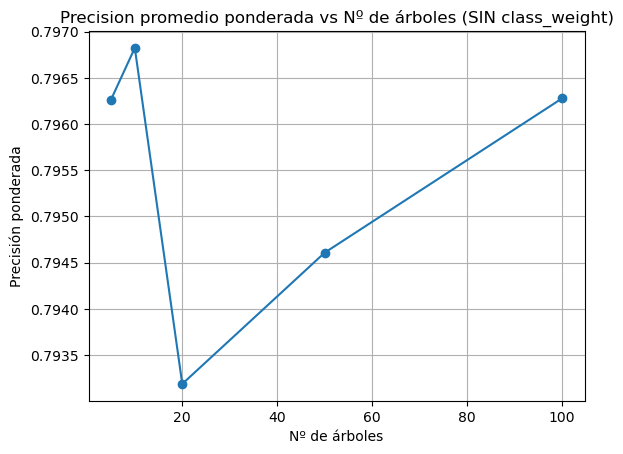

In [64]:
# Visualizamos la precisión ponderada para cada modelo
plt.plot(list(precision_weighted.keys()), list(precision_weighted.values()), marker='o')
plt.title('Precision promedio ponderada vs Nº de árboles (SIN class_weight)')
plt.xlabel('Nº de árboles')
plt.ylabel('Precisión ponderada')
plt.grid(True)
plt.show()

### Precision para modelos CON 'class_weight'

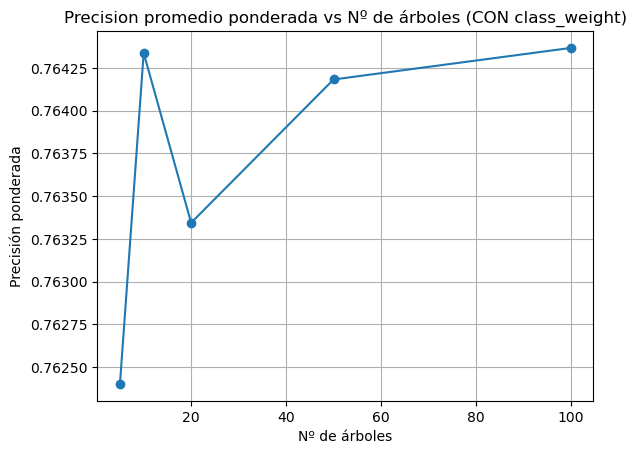

In [67]:
# Visualizamos la precisión ponderada para cada modelo
plt.plot(list(precision_weighted_balanced.keys()), list(precision_weighted_balanced.values()), marker='o')
plt.title('Precision promedio ponderada vs Nº de árboles (CON class_weight)')
plt.xlabel('Nº de árboles')
plt.ylabel('Precisión ponderada')
plt.grid(True)
plt.show()

### Recall para cada clase del modelo 20 árboles SIN 'class_weight'

In [70]:
# Calculamos las predicciones unicamente para el modelo de 20 árboles
rf_20_trees = randomForest[2]
y_pred_20 = rf_20_trees.predict(X_test)

report2 = classification_report(y_test, y_pred_20, output_dict=True)

# Mostrar el recall para cada clase
print('Recall para cada clase (SIN class_weigth):\n')
for clase, metrics in report2.items():
    if clase not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Clase {clase}: Recall = {metrics['recall']:.4f}")

# Comparar las precisiones
print("\nPrecisión SIN class_weight:\n")
for clase, metrics in report2.items():
    if clase not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Clase {clase}: Precisión = {metrics['precision']:.4f}")

Recall para cada clase (SIN class_weigth):

Clase 1: Recall = 0.7598
Clase 2: Recall = 0.8618
Clase 3: Recall = 0.8500
Clase 4: Recall = 0.6685
Clase 5: Recall = 0.2385
Clase 6: Recall = 0.3558
Clase 7: Recall = 0.7215

Precisión SIN class_weight:

Clase 1: Precisión = 0.7934
Clase 2: Precisión = 0.7906
Clase 3: Precisión = 0.7698
Clase 4: Precisión = 0.8352
Clase 5: Precisión = 0.8598
Clase 6: Precisión = 0.7100
Clase 7: Precisión = 0.9021


### Recall para cada clase del modelo 20 árboles CON 'class_weight'

In [76]:
# Calculamos las predicciones unicamente para el modelo de 20 árboles
rf_20_trees_balanced = randomForest_balanced[2]
y_pred_20_balanced = rf_20_trees_balanced.predict(X_test)

report2_balanced = classification_report(y_test, y_pred_20_balanced, output_dict=True)

# Mostrar el recall para cada clase
print('Recall para cada clase (CON class_weigth):\n')
for clase, metrics in report2_balanced.items():
    if clase not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Clase {clase}: Recall = {metrics['recall']:.4f}")

# Comparar las precisiones
print("\nPrecisión CON class_weight:\n")
for clase, metrics in report2_balanced.items():
    if clase not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Clase {clase}: Precisión = {metrics['precision']:.4f}")

Recall para cada clase (CON class_weigth):

Clase 1: Recall = 0.7182
Clase 2: Recall = 0.6055
Clase 3: Recall = 0.7593
Clase 4: Recall = 0.9487
Clase 5: Recall = 0.9191
Clase 6: Recall = 0.8407
Clase 7: Recall = 0.9405

Precisión CON class_weight:

Clase 1: Precisión = 0.7517
Clase 2: Precisión = 0.8281
Clase 3: Precisión = 0.8021
Clase 4: Precisión = 0.6427
Clase 5: Precisión = 0.1428
Clase 6: Precisión = 0.4360
Clase 7: Precisión = 0.5072


### Matriz de confusion modelo 20 árboles SIN 'class_weight'

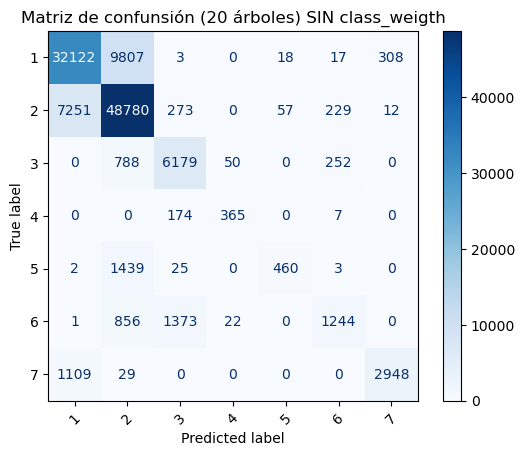

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred_20)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_20_trees.classes_)

# Mostramos la matriz
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de confunsión (20 árboles) SIN class_weigth')
plt.show()

### Matriz de confusion modelo 20 árboles CON 'class_weight'

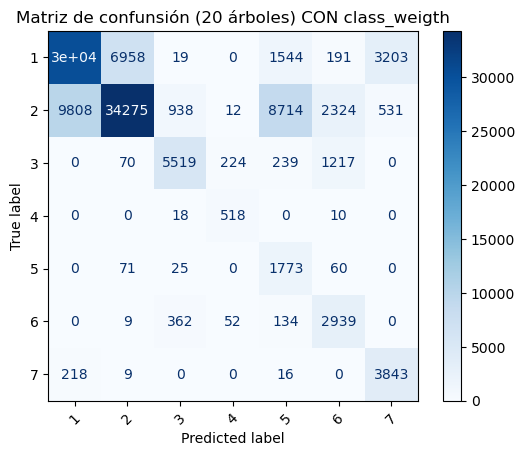

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Creamos la matriz de confusión
cm_balanced = confusion_matrix(y_test, y_pred_20_balanced)
disp_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_balanced, display_labels=rf_20_trees_balanced.classes_)

# Mostramos la matriz
disp_balanced.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de confunsión (20 árboles) CON class_weigth')
plt.show()

- La matriz de confusión nos permite analizar cómo se distribuyen las precicciones correctas e incorrectas para cada clase. Las clases mayoritarias `1` y `2`, con mayor número de ejemplos, tienen una mayor cantidad de aciertos en proporción. Las clases minoritarias se clasifican peor debido al desbalance, y aunque la clase `3` tenga un buen número de aciertos, tiene tambien una alta tasa de errores (falsos positivos y negativos).

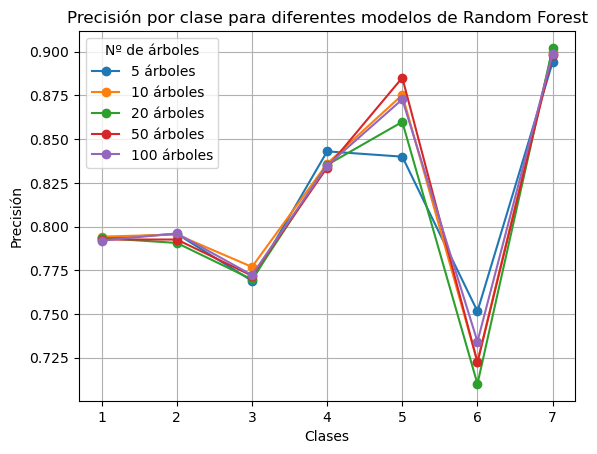

In [84]:
# Diccionario para almacenar precisiones por clase para cada modelo
precision_por_clase = {}

# Evaluar cada modelo
for rf in randomForest:
    # Predicciones
    y_pred = rf.predict(X_test)
    
    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Guardar precisión por clase
    precision_por_clase[rf.n_estimators] = {clase: metrics['precision'] for clase, metrics in report.items() if clase not in ['accuracy', 'macro avg', 'weighted avg']}

# Representar cada modelo con una línea de un color
for n_estimators, precisiones in precision_por_clase.items():
    clases = list(precisiones.keys())
    valores = list(precisiones.values())
    plt.plot(clases, valores, marker='o', label=f'{n_estimators} árboles')

# Configuración del gráfico
plt.title('Precisión por clase para diferentes modelos de Random Forest')
plt.xlabel('Clases')
plt.ylabel('Precisión')
plt.legend(title='Nº de árboles')
plt.grid(True)
plt.show()

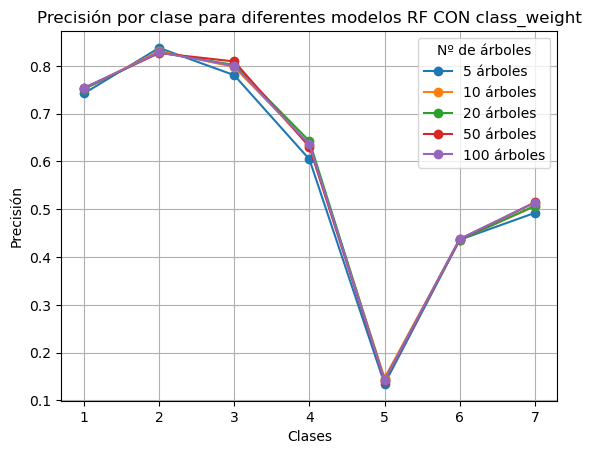

In [86]:
# Diccionario para almacenar precisiones por clase para cada modelo
precision_por_clase_balanced = {}

# Evaluar cada modelo
for rf in randomForest_balanced:
    # Predicciones
    y_pred = rf.predict(X_test)
    
    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Guardar precisión por clase
    precision_por_clase_balanced[rf.n_estimators] = {clase: metrics['precision'] for clase, metrics in report.items() if clase not in ['accuracy', 'macro avg', 'weighted avg']}

# Representar cada modelo con una línea de un color
for n_estimators, precisiones in precision_por_clase_balanced.items():
    clases = list(precisiones.keys())
    valores = list(precisiones.values())
    plt.plot(clases, valores, marker='o', label=f'{n_estimators} árboles')

# Configuración del gráfico
plt.title('Precisión por clase para diferentes modelos RF CON class_weight')
plt.xlabel('Clases')
plt.ylabel('Precisión')
plt.legend(title='Nº de árboles')
plt.grid(True)
plt.show()

- Teniendo en cuenta la precisión promedio ponderada para cada uno de los modelos, se podría elegir el modelo de 10 o 100 árboles por obtener los valores más altos de precisión. Lo que no es del todo fiable ya que al estar frente a un dataset desbalanceado, tendrá más en cuenta las clases mayoritarias a la hora de hacer el promedio de la precisión.
- Si analizamos la precisión de cada modelo para cada clase, podríamos decantarnos por el modelo de 50 árboles, al conseguir los valores más altos de precisión en clases minoritarias como son la `5` y la `7`, aunque mantiene un comportamiento muy similar, en términos de precisión, al resto de modelos.

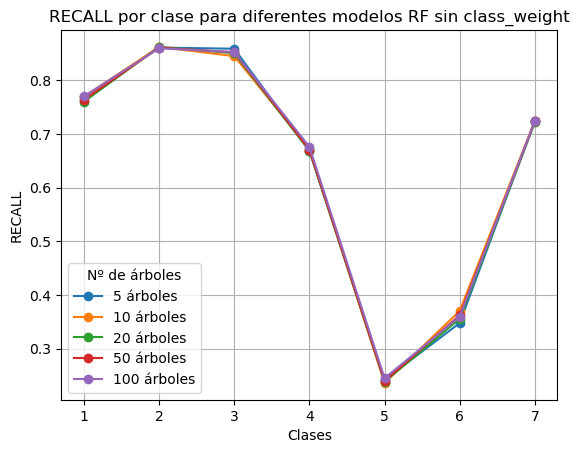

In [95]:
# Diccionario para almacenar precisiones por clase para cada modelo
precision_por_clase = {}

# Evaluar cada modelo
for rf in randomForest:
    # Predicciones
    y_pred = rf.predict(X_test)
    
    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Guardar precisión por clase
    precision_por_clase[rf.n_estimators] = {clase: metrics['recall'] for clase, metrics in report.items() if clase not in ['accuracy', 'macro avg', 'weighted avg']}

# Representar cada modelo con una línea de un color
for n_estimators, precisiones in precision_por_clase.items():
    clases = list(precisiones.keys())
    valores = list(precisiones.values())
    plt.plot(clases, valores, marker='o', label=f'{n_estimators} árboles')

# Configuración del gráfico
plt.title('RECALL por clase para diferentes modelos RF sin class_weight')
plt.xlabel('Clases')
plt.ylabel('RECALL')
plt.legend(title='Nº de árboles')
plt.grid(True)
plt.show()

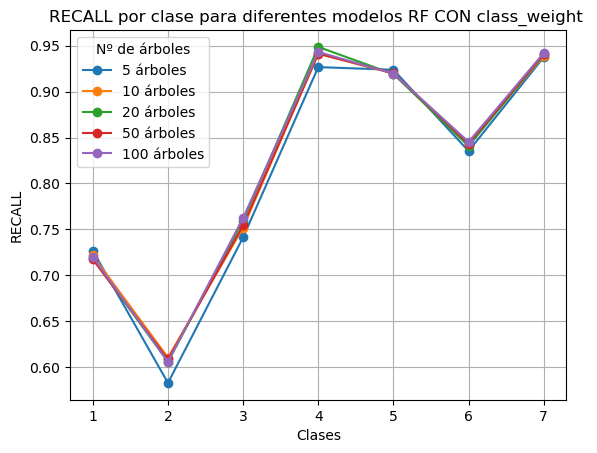

In [97]:
# Diccionario para almacenar precisiones por clase para cada modelo
precision_por_clase_balanced = {}

# Evaluar cada modelo
for rf in randomForest_balanced:
    # Predicciones
    y_pred = rf.predict(X_test)
    
    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Guardar precisión por clase
    precision_por_clase_balanced[rf.n_estimators] = {clase: metrics['recall'] for clase, metrics in report.items() if clase not in ['accuracy', 'macro avg', 'weighted avg']}

# Representar cada modelo con una línea de un color
for n_estimators, precisiones in precision_por_clase_balanced.items():
    clases = list(precisiones.keys())
    valores = list(precisiones.values())
    plt.plot(clases, valores, marker='o', label=f'{n_estimators} árboles')

# Configuración del gráfico
plt.title('RECALL por clase para diferentes modelos RF CON class_weight ')
plt.xlabel('Clases')
plt.ylabel('RECALL')
plt.legend(title='Nº de árboles')
plt.grid(True)
plt.show()

- Teniendo en cuenta que cada modelo ofrece precisiones bastante similares en la mayoría de clases, se selecciona el modelo de 100 árboles por obtener de los valores más altos de precisión en muchas clases y además en Random Forest al tener más árboles implica un modelo mas estable. En este caso al ser un número de árboles cuyo coste computacional no influye en la decisión, se decide por este número de árboles.

#### Evaluacion del modelo final elegido: 100 árboles

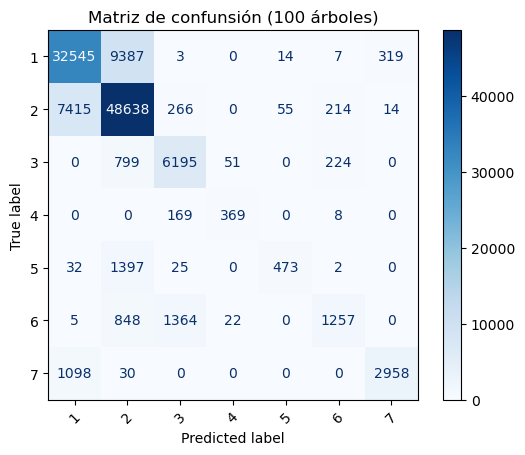

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Accedemos al modelo con 20 arboles y volvemos a predecir los valores
rf_100_trees = randomForest[4]

y_pred_100 = rf_100_trees.predict(X_test)

# Creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred_100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_100_trees.classes_)

# Mostramos la matriz
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de confunsión (100 árboles)')
plt.show()

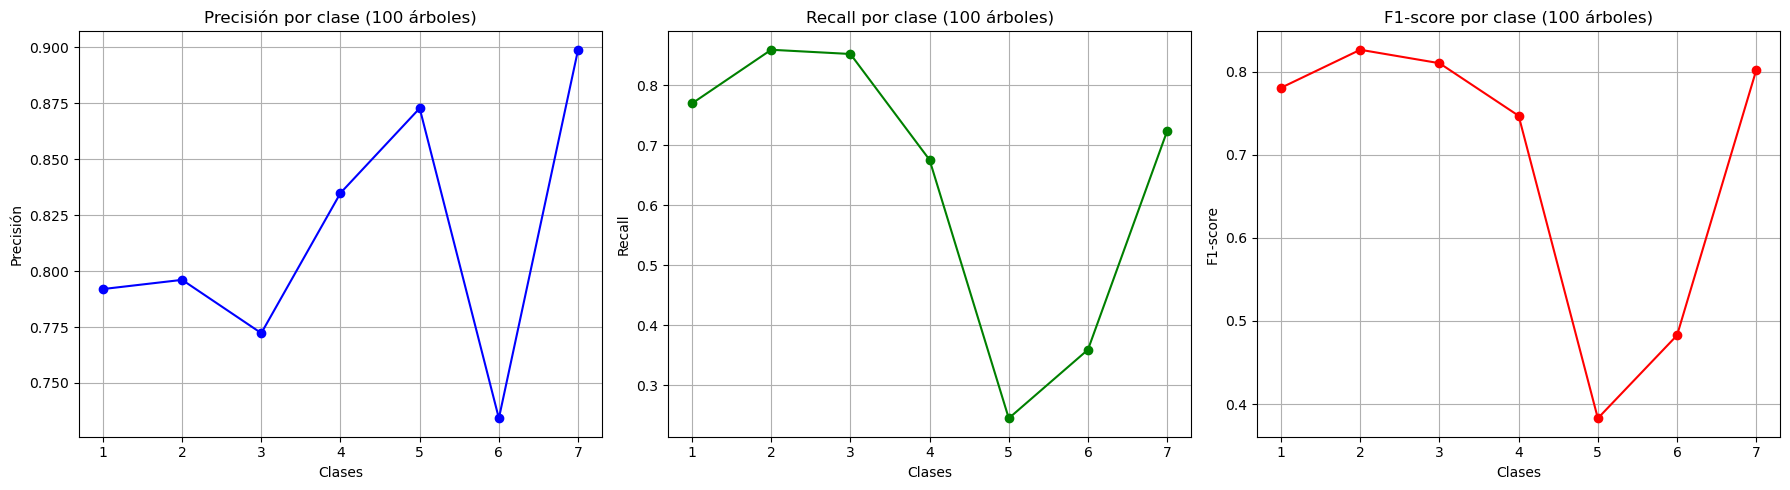

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Seleccionar el modelo con 100 árboles
rf_100_trees = randomForest[4]

# Predicciones
y_pred_100 = rf_100_trees.predict(X_test)

# Reporte de clasificación
report_100 = classification_report(y_test, y_pred_100, output_dict=True)

# Extraer métricas por clase
clases = [clase for clase in report_100.keys() if clase not in ['accuracy', 'macro avg', 'weighted avg']]
precision = [report_100[clase]['precision'] for clase in clases]
recall = [report_100[clase]['recall'] for clase in clases]
f1_score = [report_100[clase]['f1-score'] for clase in clases]

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de Precisión
axes[0].plot(clases, precision, marker='o', color='b', label='Precisión')
axes[0].set_title('Precisión por clase (100 árboles)')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Precisión')
axes[0].grid(True)

# Gráfico de Recall
axes[1].plot(clases, recall, marker='o', color='g', label='Recall')
axes[1].set_title('Recall por clase (100 árboles)')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Recall')
axes[1].grid(True)

# Gráfico de F1-score
axes[2].plot(clases, f1_score, marker='o', color='r', label='F1-score')
axes[2].set_title('F1-score por clase (100 árboles)')
axes[2].set_xlabel('Clases')
axes[2].set_ylabel('F1-score')
axes[2].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()


- No clasifica por igual todas las clases, las clases `1`, `2`, `3`, `4` y `7` muestran valores de f1-score y recall sustancialmente altos, mientras que para las clases `5` y `6` estos valores son muy bajos, lo que indica que el modelo tiene más dificultad para predecir correctamente esas dos clases.

### 2. Support Vector Machine

In [107]:
# Importamos las librerías para utilizar las máquinas de vector de soportes.
# Utilizaremos la librería svm:
from sklearn import svm

#Cargamos también las librerías para hacer la matriz de confusión y la cross validation:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

El algoritmo de SVM necesita ajustar una serie de hiperparámetros para realizar las clasificaciones. La implementación de sklearn nos da mucha flexibilidad para nuestros modelos. En general, para los problemas más comunes de clasificación son:

- `C`: controla el equilibrio entre la maximización del margen y la penalización de los errores de clasificación. Valor alto da más importancia a clasificar correctamente los ejemplos, implicando margen más estrecho y posible sobreajuste. Valor bajo permite margen más amplio, con el objetivo de lograr mayor generalización.
- `kernel`: define la función que se utiliza para transformar los datos en un espacio de mayor dimensión donde sean más facilmente separables.
- `degree`: define el grado del polinomio cuando se usa el kernel polinómico (`kernel=poly`).
- `gamma`: controla la influencia de un solo punto de entrenamiento en los datos transformados.

- El hiperparámetro `decision_function_shape` controla cómo se calcula la función de decisión en problemas de clasificación multiclase.
- Es útil porque afecta a cómo el modelo maneja problemas de clasificación para más de dos clases. En este caso tenemos 7 clases y un dataset desbalanceado, por lo que podría ser una buena opción usar el enfoque `ovr` para reforzar la detección de las clases minoritarias ya que se asegura dde que cada clase tenga su propio clasificador contra todas las demas.

**NOTA** Tenemos un dataset de más de medio millón de instancias, y para el objetivo de este estudio no hacen falta tantas. Por eso, antes de aplicar SVM vamos a reducir el número de instancias. SVM requiere una gran carga computacional y con ese volumen de instancias el tiempo requerido sería demasiado elevado.

In [112]:
X2 = X.head(10000)
y2 = y.head(10000)

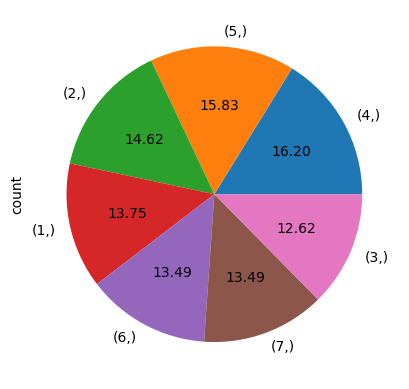

In [114]:
y2.value_counts().plot(kind='pie',autopct='%.2f',)
plt.show()

In [116]:
# Con el nuevo número de instancias, separamos los datos en los conjuntos de entrenamiento y test.
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X2, y2, test_size=0.2, random_state=1)

- En este caso si es recomendable normalizar o escalar los datos antes de entrenar el modelo de SVM, ya que el cálculo de la frontera de decisión se basa en medidas de distancia. Claramente esto es solo para variables continuas, en el caso de las variables categóricas podriamos hacer sería codificarlas para que el clasificador pueda tratar con valores numéricos, pero esto ya esta así en nuestro dataset.

In [119]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame


scaler = StandardScaler()

# Convertimos las variables continuas en tipo float para evitar el FutureWarning del que nos avisan
X_train[con_vars] = X_train[con_vars].astype(float)
X_test[con_vars] = X_test[con_vars].astype(float)

X_train.loc[:, con_vars] = scaler.fit_transform(X_train[con_vars])
X_test.loc[:, con_vars] = scaler.fit_transform(X_test[con_vars])

#### 2.1 Entrenamiento de modelos

In [122]:
from sklearn.svm import SVC

C = [0.1, 1, 10, 100, 1000]
kernel = 'rbf'
gamma = 'scale'

svc_models = [SVC(C=i, kernel=kernel, gamma=gamma) for i in C]

for model in svc_models:
    # Entrenamiento
    model.fit(X_train, y_train)

C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Simon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

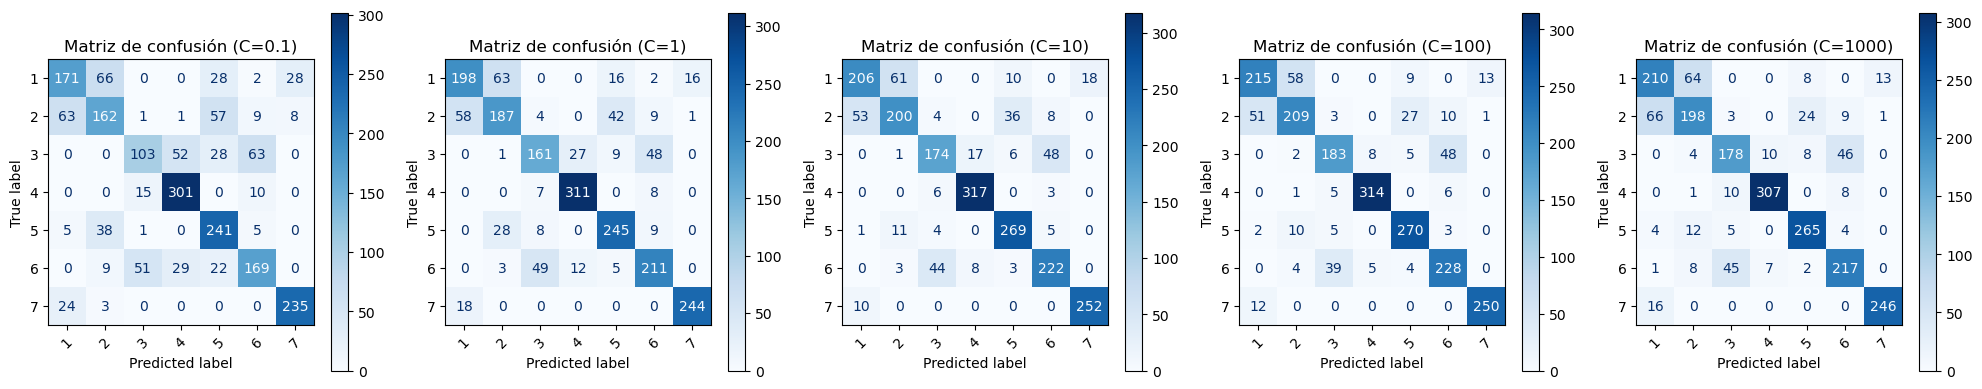

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Creamos una figura con 5 subplots (uno por cada valor de C)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
diagonal={}

for ax, c_val, model in zip(axes, C, svc_models):
    # Obtenemos las predicciones con cada modelo
    y_pred = model.predict(X_test)
    
    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Calculamos el total de ejemplos que ha clasificado bien cada modelo
    diagonal[c_val] = cm.diagonal().sum()
    
    # Creamos el objeto para mostrarla
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    
    # Dibujamos la matriz en el subplot correspondiente
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    
    # Añadimos el título al subplot con el valor de C
    ax.set_title(f'Matriz de confusión (C={c_val})')

plt.tight_layout()
plt.show()

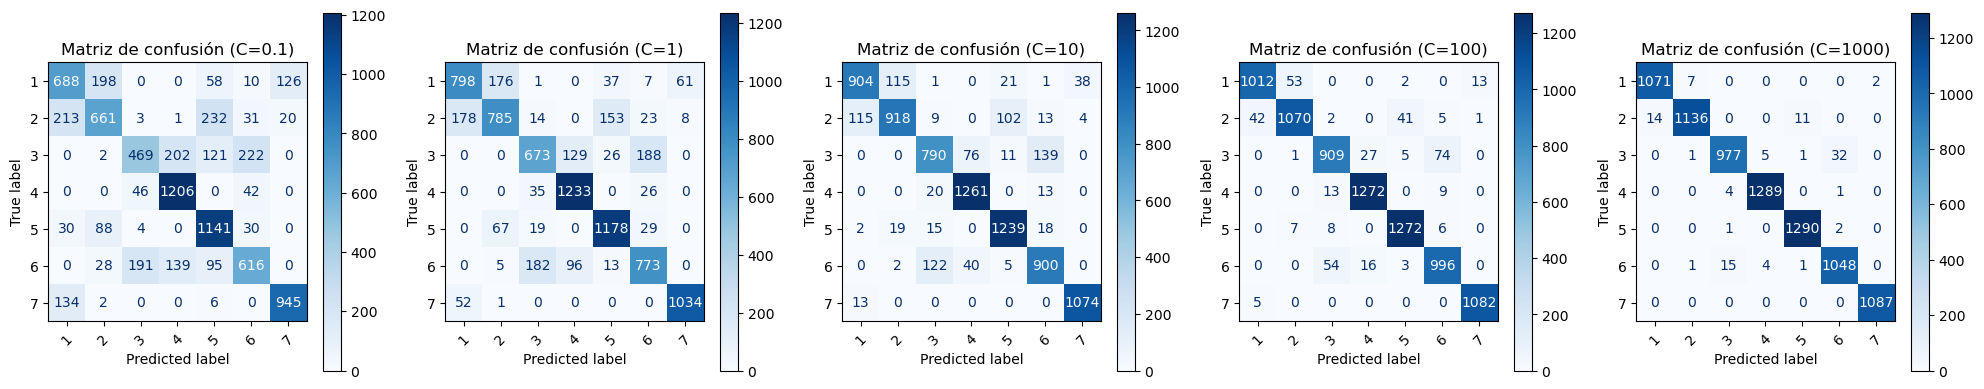

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Creamos una figura con 5 subplots (uno por cada valor de C)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
diagonal={}

for ax, c_val, model in zip(axes, C, svc_models):
    # Obtenemos las predicciones con cada modelo
    y_pred_train = model.predict(X_train)
    
    # Calculamos la matriz de confusión
    cm = confusion_matrix(y_train, y_pred_train)

    # Calculamos el total de ejemplos que ha clasificado bien cada modelo
    diagonal[c_val] = cm.diagonal().sum()
    
    # Creamos el objeto para mostrarla
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    
    # Dibujamos la matriz en el subplot correspondiente
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    
    # Añadimos el título al subplot con el valor de C
    ax.set_title(f'Matriz de confusión (C={c_val})')

plt.tight_layout()
plt.show()

In [128]:
print("Ejemplos clasificados correctamente en cada uno de los modelos:")
print(diagonal)

Ejemplos clasificados correctamente en cada uno de los modelos:
{0.1: 5726, 1: 6474, 10: 7086, 100: 7613, 1000: 7898}


- Modelo `C=0.1`: **1382** verdaderos positivos
- Modelo `C=1`: **1557** verdaderos positivos
- Modelo `C=10`: **1640** verdaderos positivos
- Modelo `C=100`: **1669** verdaderos positivos
- Modelo `C=1000`: **1621** verdaderos positivos

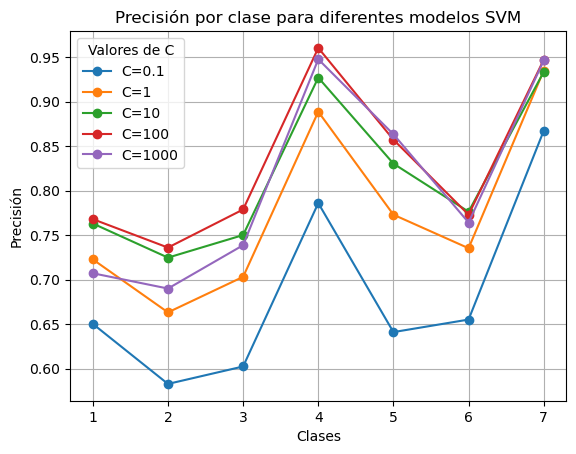

In [133]:
# Diccionario para almacenar precisiones por clase para cada modelo
precision_por_clase = {}

# Evaluar cada modelo
for model in svc_models:
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Guardar precisión por clase
    precision_por_clase[model.C] = {clase: metrics['precision'] for clase, metrics in report.items() if clase not in ['accuracy', 'macro avg', 'weighted avg']}

# Representar cada modelo con una línea de un color
for C, precisiones in precision_por_clase.items():
    clases = list(precisiones.keys())
    valores = list(precisiones.values())
    plt.plot(clases, valores, marker='o', label=f'C={C}')

# Configuración del gráfico
plt.title('Precisión por clase para diferentes modelos SVM')
plt.xlabel('Clases')
plt.ylabel('Precisión')
plt.legend(title='Valores de C')
plt.grid(True)
plt.show()

- En términos de precisión para cada clase, se puede determinar el modelo con C=100 como el más óptimo. Tal y como se observa en el gráfico obtenemos valores más altos de precisión en todas las clases con la salvedad de la clase 5 donde el modelo con C=1000, le supera muy sutilmente.

#### Evaluación del modelo final elegido: C=100

In [137]:
model = svc_models[3]
y_pred = model.predict(X_test)

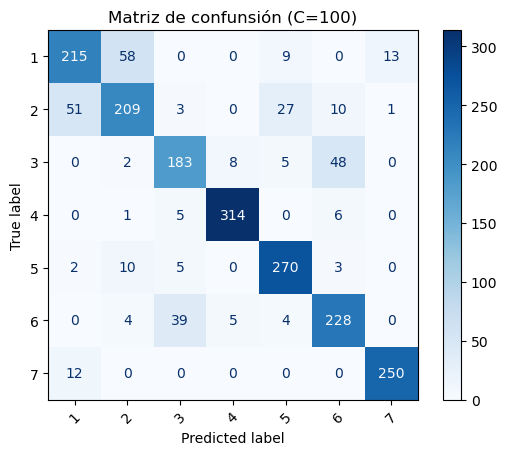

El modeo ha clasificado bien 1669

El modeo ha clasificado mal 331



In [139]:
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Calculamos TP y FP
total = cm.sum()
TP = cm.diagonal().sum()
FP = total - TP

# Creamos el objeto para mostrarla
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)

# Mostramos la matriz
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de confunsión (C=100)')
plt.show()


# Mostramos cuantos TP y FP hay
print(f"El modeo ha clasificado bien {TP}\n")
print(f"El modeo ha clasificado mal {FP}\n")

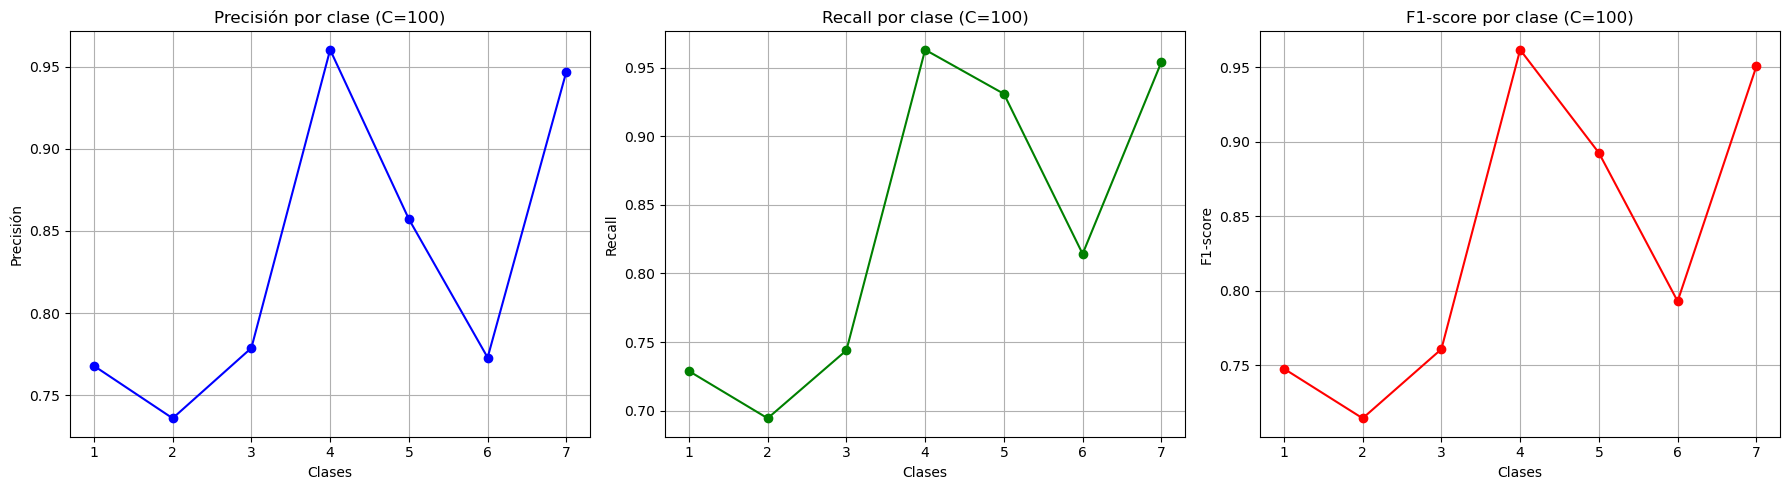

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Seleccionar el modelo
model = svc_models[3]

# Predicciones
y_pred_100 = model.predict(X_test)

# Reporte de clasificación
report_100 = classification_report(y_test, y_pred_100, output_dict=True)

# Extraer métricas por clase
clases = [clase for clase in report_100.keys() if clase not in ['accuracy', 'macro avg', 'weighted avg']]
precision = [report_100[clase]['precision'] for clase in clases]
recall = [report_100[clase]['recall'] for clase in clases]
f1_score = [report_100[clase]['f1-score'] for clase in clases]

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de Precisión
axes[0].plot(clases, precision, marker='o', color='b', label='Precisión')
axes[0].set_title('Precisión por clase (C=100)')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Precisión')
axes[0].grid(True)

# Gráfico de Recall
axes[1].plot(clases, recall, marker='o', color='g', label='Recall')
axes[1].set_title('Recall por clase (C=100)')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Recall')
axes[1].grid(True)

# Gráfico de F1-score
axes[2].plot(clases, f1_score, marker='o', color='r', label='F1-score')
axes[2].set_title('F1-score por clase (C=100)')
axes[2].set_xlabel('Clases')
axes[2].set_ylabel('F1-score')
axes[2].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()


- En este caso, donde como hemos visto al principio, esta vez si esta balanceado el dataset con el mismo numero de ejemplos por cada clase, casualidad de los 10k primeros registros del dataset. Debido a esto y al correcto funcionamiento del modelo SVM con un parámetro C=100, obtenemos valores considerablemente altos en las tres medidas, entrando en un rango de [0.7, 0.97] para los tres casos. Esto nos indica que se obtiene una buena capacidad predictiva para todas las clases, siendo en algunos casos (`4` y `7`) excelente, por tanto podemos decir que tiene un buen comportamiento de prediccion para todas las clases. Si se precisa un poco mas la respuesta, podemos decir que las clases `1`, `2` y `3` tienen menor capacidad predictiva ya que se han evaluado más falsos positivos para estos casos. Sin embargo en comparación con la gran diferencia que habia en el modelo de Random Forest en la capacidad predictiva de algunas clases, podemos decir que este modelo se comporta correctamente para todas las clases.